Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

- Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

- Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

- Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

- Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

Выполнить задание 2 для трех моделей.

- (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

- (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [3]:
#!pip install catboost

In [4]:
import catboost as cb

In [5]:
import warnings
warnings.simplefilter("ignore")

In [8]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=5000,
            verbose=50)

        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
        
    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=5000,
            cat_features=categorical)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [16]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_features = df.select_dtypes(include=[np.object])
    categorical_columns = categorical_features.columns.to_list()
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
df_app = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/applications_history.csv')
df_bki = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/bki.csv')
df_clp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/client_profile.csv')
df_pay = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/payments.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/train.csv')
#df_sample = pd.read_csv('../input/geekbrain-data-analysis/sample_submit.csv')

print("df_app.shape = {} rows, {} cols".format(*df_app.shape))
print("df_bki.shape = {} rows, {} cols".format(*df_bki.shape))
print("df_clp.shape = {} rows, {} cols".format(*df_clp.shape))
print("df_pay.shape = {} rows, {} cols".format(*df_pay.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))

df_app.shape = 1670214 rows, 26 cols
df_bki.shape = 945234 rows, 17 cols
df_clp.shape = 250000 rows, 24 cols
df_pay.shape = 1023932 rows, 8 cols
df_test.shape = 165141 rows, 2 cols
df_train.shape = 110093 rows, 3 cols


In [9]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [10]:
# объединяем трейн и тест
data = pd.concat([df_train, df_test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [11]:
data.shape

(275234, 3)

In [12]:
df_clp = clean_input(df_clp)
data = clean_input(data)

shape = 250000 rows, 24 cols
shape = 275234 rows, 3 cols


In [17]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X['gender'] = X['gender'].replace('XNA', np.nan)    # поменяем 4 значения на пола на F
    X['total_salary'] = X['total_salary'].replace(117000000.0, X['total_salary'].median())
    X = X[X['total_salary'] < 20000000] # удаляем выбросы
    # NaN значения для 'days_on_last_job': 365243 -> nan
    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    
    # One-hot encoding
    X, cat_cols = one_hot_encoder(X, nan_as_category=False)

    def get_age_label(age):
        """ Return the age group label (int). """
        age_years = age / 365
        if age_years < 27: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 65: return 4
        elif age_years < 99: return 5
        else: return 0

    # сегментация по возрасту
    X['age_range'] = X['age'].apply(lambda x: get_age_label(x))
    
    # самые важные признаки (веса - по важности)
    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3
    # X["log_external_scoring_rating_1"] = np.log(X["external_scoring_rating_1"])
    # X["log_external_scoring_rating_2"] = np.log(X["external_sco ring_rating_2"])
    # X["log_external_scoring_rating_3"] = np.log(X["external_scoring_rating_3"])

    # статистики по самым важным признакам
    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )
    # Отношение врменных признаков
    # возраст к стажу
    X['ratio_experience_to_age'] = X["days_on_last_job"] / X["age"]
    X['ratio_salary_to_credit'] = X['total_salary'] / X['amount_credit']
    # сколько зарплат клиент хочет одолжить = сумма кредита / суммы зарплаты
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    X['income_per_person'] = X['total_salary'] / X['family_size']
    # какую долю зарплаты клиент отдаёт за кредит = сумма платежа / зарплату
    X['percent_annuity_salary'] = X['amount_annuity'] / X['total_salary']
    # Отношение между основными фин. показателями
    # срок кредита = сумма кредиты / срок платежа
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    
    # Отношение фин. показателей к возрасту и временным фичам
    # гипотеза:молодые агрессивнее берут кредиты, чем в возрасте
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]

    # свободные средства, остающиеся после выплаты кредита
    X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # регион клиента выражается в нормированом количестве жителей региона
    # насколько клиент по своей зарплате выделяется по своему региону
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    ######################
    X['ratio_external_scoring_rating_1_to_age'] = X['external_scoring_rating_1'] / (X['age'] / 365.25)
    X['ratio_external_scoring_rating_2_to_age'] = X['external_scoring_rating_2'] / (X['age'] / 365.25)
    X['ratio_external_scoring_rating_3_to_age'] = X['external_scoring_rating_3'] / (X['age'] / 365.25)
    ######################
    X['ratio_external_scoring_rating_1_to_job'] = X['external_scoring_rating_1'] / (X['days_on_last_job'] / 365.25)
    X['ratio_external_scoring_rating_1_external_scoring_rating_2_to_age'] = X['external_scoring_rating_1'] * X['external_scoring_rating_2'] * X['age']
    X['ratio_external_scoring_rating_1_to_fam_size'] = X['external_scoring_rating_1'] / X['family_size']
    ######################
    X['ratio_external_scoring_rating_1_to_amount_credit'] = X['external_scoring_rating_1'] / X['amount_credit']
    X['ratio_external_scoring_rating_1_to_scoring_2'] = X['external_scoring_rating_1'] / X['external_scoring_rating_2']
    X['ratio_external_scoring_rating_1_to_scoring_3'] = X['external_scoring_rating_1'] / X['external_scoring_rating_3']
    X['ratio_external_scoring_rating_2_to_scoring_3'] = X['external_scoring_rating_2'] / X['amount_credit']
    ######################
    X['external_scoring_rating_2*region_population'] = X['external_scoring_rating_2'] / X['region_population']
    X['external_scoring_rating_1*external_scoring_rating_2'] = X['external_scoring_rating_1'] * X['external_scoring_rating_2']
    X['external_scoring_rating_1*external_scoring_rating_3'] = X['external_scoring_rating_1'] * X['external_scoring_rating_3']
    X['external_scoring_rating_2*external_scoring_rating_3'] = X['external_scoring_rating_2'] * X['external_scoring_rating_3']
    ######################   
    X['external_scoring_rating_1*days_on_last_job'] = X['external_scoring_rating_1'] * X['days_on_last_job']
    X['external_scoring_rating_2*days_on_last_job'] = X['external_scoring_rating_2'] * X['days_on_last_job']
    X['external_scoring_rating_3*days_on_last_job'] = X['external_scoring_rating_3'] * X['days_on_last_job']

    X['total_salary/12_amount_annuity_ratio_diff'] = X['total_salary'] / 12. - X['amount_annuity']
    X['age_days_on_last_job_diff'] = X['age'] - X['days_on_last_job']

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

In [18]:
# для задания будем использовать только client_profile

In [19]:
# создадим новые признаки
df_clp = create_client_profile_features(df_clp)
df_clp.head()

,application_number,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,gender_F,gender_M,education_level_Academic degree,education_level_Higher education,education_level_Incomplete higher,education_level_Lower secondary,education_level_Secondary / secondary special,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Unknown,family_status_Widow,age_range,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,...,ratio_salary_to_credit,ratio_credit_to_salary,income_per_person,percent_annuity_salary,ratio_credit_to_annuity,ratio_salary_to_age,ratio_salary_to_experience,ratio_annuity_to_age,ratio_annuity_to_experience,ratio_credit_to_age,ratio_credit_to_experience,total_salary_net,ratio_car_to_age,ratio_car_to_experience,ratio_salary_to_region_population,ratio_external_scoring_rating_1_to_age,ratio_external_scoring_rating_2_to_age,ratio_external_scoring_rating_3_to_age,ratio_external_scoring_rating_1_to_job,ratio_external_scoring_rating_1_external_scoring_rating_2_to_age,ratio_external_scoring_rating_1_to_fam_size,ratio_external_scoring_rating_1_to_amount_credit,ratio_external_scoring_rating_1_to_scoring_2,ratio_external_scoring_rating_1_to_scoring_3,ratio_external_scoring_rating_2_to_scoring_3,external_scoring_rating_2*region_population,external_scoring_rating_1*external_scoring_rating_2,external_scoring_rating_1*external_scoring_rating_3,external_scoring_rating_2*external_scoring_rating_3,external_scoring_rating_1*days_on_last_job,external_scoring_rating_2*days_on_last_job,external_scoring_rating_3*days_on_last_job,total_salary/12_amount_annuity_ratio_diff,age_days_on_last_job_diff,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,0,157500.0,270000.0,13500.0,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0.052832,2.930959,0.236315,0.678568,0.414784,...,0.583333,1.714286,78750.0,0.085714,20.000000,18.399533,101.678502,1.577103,8.715300,31.542056,174.306004,144000.0,NaN,NaN,1270.7100,0.014058,0.010083,0.028954,0.077688,666.471307,0.164735,0.000001,1.394204,0.485539,8.752396e-07,29.290368,0.077859,0.223568,0.160356,510.350317,366.051456,1051.101350,-375.0,7011.0,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,0,270000.0,536917.5,28467.0,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,1,0,0,0,0,0,1,0,1,0,0,0,0,4,NaN,NaN,0.442295,0.802745,0.622520,...,0.502871,1.988583,135000.0,0.105433,18.861050,11.644456,NaN,1.227714,NaN,23.155971,NaN,241533.0,NaN,NaN,5466.4200,NaN,0.006967,0.012645,NaN,NaN,NaN,NaN,NaN,NaN,8.237665e-07,21.846027,NaN,NaN,0.355050,NaN,NaN,NaN,-5967.0,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462
2,123501780,1,427500.0,239850.0,23850.0,0.072508,14387,326.0,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,0,1,0,0,0,0,2,NaN,NaN,0.409017,0.738159,0.573588,...,1.782364,0.561053,142500.0,0.055789,10.056604,29.714325,1311.349693,1.657747,73.159509,16.671300,735.736196,403650.0,0.001251,0.055215,30997.1700,0.010384,0.018740,NaN,0.458262,4343.716524,0.136339,0.000002,0.554104,NaN,3.077586e-06,10.180380,0.301920,NaN,NaN,133.339535,240.639821,NaN,11775.0,14061.0,98102.721947,177047.426953,NaN,9755.054903,17605.091235,NaN
3,123588799,0,112500.0,254700.0,17149.5,0.019101,14273,1726.0,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0,0,1,0,0,0,0,1,0,1,0,0,0,0,2,NaN,NaN,0.308994,0.59023

In [20]:
data = data.merge(
    df_clp, how="left", on="application_number"
)

In [21]:
data.shape

(275234, 85)

In [22]:
# выделяем по маске данные из трейна и из теста
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

# разделяем на трейн и тест
train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

# заменяем некорректные значения, которые могли образоваться в результате деления
train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)
test = test.replace(np.inf, np.nan)
test = test.replace(-np.inf, np.nan)

In [23]:
name_contract_type_dict = {
    'Cash': 0, 'Credit Card': 1   
}

In [24]:
train.name_contract_type = train.name_contract_type.map(name_contract_type_dict)
test.name_contract_type = test.name_contract_type.map(name_contract_type_dict)

In [25]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [26]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)

In [27]:
lgb_estimators, lgb_oof_preds = lightgbm_cross_validation(
    params=lgbm_params, X=train, y=target, cv=cv)

# метрика качества
lgb_oof_score = roc_auc_score(
    target, lgb_oof_preds
)

Mon Nov  1 10:18:58 2021, Cross-Validation, 110093 rows, 83 cols
Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.270511	valid_0's auc: 0.722032
[100]	valid_0's binary_logloss: 0.26455	valid_0's auc: 0.724105
[150]	valid_0's binary_logloss: 0.260767	valid_0's auc: 0.726103
[200]	valid_0's binary_logloss: 0.258107	valid_0's auc: 0.727902
[250]	valid_0's binary_logloss: 0.256212	valid_0's auc: 0.729467
[300]	valid_0's binary_logloss: 0.254808	valid_0's auc: 0.7309
[350]	valid_0's binary_logloss: 0.253726	valid_0's auc: 0.732459
[400]	valid_0's binary_logloss: 0.252915	valid_0's auc: 0.733109
[450]	valid_0's binary_logloss: 0.252207	valid_0's auc: 0.734652
[500]	valid_0's binary_logloss: 0.251549	valid_0's auc: 0.736221
[550]	valid_0's binary_logloss: 0.251075	valid_0's auc: 0.737284
[600]	valid_0's binary_logloss: 0.250612	valid_0's auc: 0.738739
[650]	valid_0's binary_logloss: 0.250216	valid_0's auc: 0.739747
[700]	valid_0's binary_logloss

In [29]:
# метрика качества
lgb_oof_score

0.7275264364001751

In [32]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "min_child_weight": 30,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=7, random_state=42, shuffle=True)

In [33]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(xgb_params, train, target, xgb_cv)

Mon Nov  1 10:34:35 2021, Cross-Validation, 110093 rows, 83 cols
[0]	validation_0-auc:0.70629	validation_1-auc:0.704421
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5000 rounds.
[50]	validation_0-auc:0.76644	validation_1-auc:0.740776
[99]	validation_0-auc:0.788458	validation_1-auc:0.742493
Fold 1, Valid score = 0.74249
[0]	validation_0-auc:0.70973	validation_1-auc:0.687641
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5000 rounds.
[50]	validation_0-auc:0.767845	validation_1-auc:0.72281
[99]	validation_0-auc:0.78893	validation_1-auc:0.725253
Fold 2, Valid score = 0.72529
[0]	validation_0-auc:0.711394	validation_1-auc:0.684803
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5000 rounds.
[50]	va

In [35]:
xgb_score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(xgb_score, 5)}")

Score = 0.72756


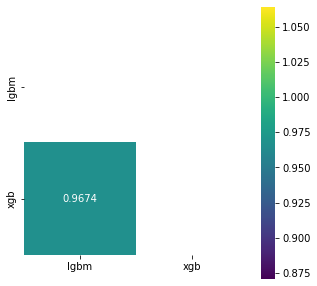

In [37]:
scores_train = pd.DataFrame({
    "lgbm": lgb_oof_preds,
    "xgb": xgb_oof,
     })

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [38]:
x_train, x_valid = train_test_split(train, train_size=0.7, shuffle=True, random_state=15)
y_train, y_valid = train_test_split(target, train_size=0.7, shuffle=True, random_state=15)

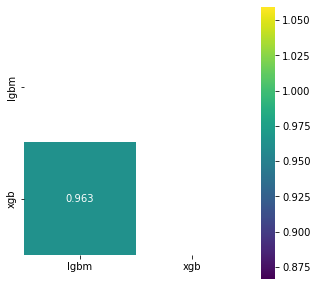

In [56]:
lgbm_pred_valid = lgb_estimators[0].predict_proba(x_valid)[:, 1]
xgb_pred_valid = xgb_estimators[0].predict_proba(x_valid)[:, 1]

scores_valid = pd.DataFrame({
    "lgbm": lgbm_pred_valid,
    "xgb": xgb_pred_valid,
     })

corr = scores_valid.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [57]:
val_statistics = pd.DataFrame(columns=['score_valid'])

In [58]:
val_statistics.loc['LightGBM', 'score_valid'] = roc_auc_score(y_valid, lgbm_pred_valid)
val_statistics.loc['XGBoost', 'score_valid'] = roc_auc_score(y_valid, xgb_pred_valid)

In [59]:
val_statistics

,score_valid
LightGBM,0.794234
XGBoost,0.784022


## 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [51]:
scores_mean = scores_valid.mean(axis=1)

In [60]:
scores_valid.head()

,lgbm,xgb
0,0.032902,0.038447
1,0.107773,0.116343
2,0.014553,0.006101
3,0.053796,0.044722
4,0.030630,0.034978


In [63]:
scores_mean = scores_valid.mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

val_statistics.loc['AMean2', 'score_valid'] = score

Score = 0.7931


In [65]:
scores_mean = gmean(scores_valid, axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7923


In [66]:
val_statistics.loc['GMean2', 'score_valid'] = score

In [72]:
# ROC-AUC / GINI
scores_mean = scores_valid.rank().mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.792


In [73]:
val_statistics.loc['Rank', 'score_valid'] = score

In [74]:
scores_mean = gmean(scores_valid.rank(), axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7905


In [75]:
val_statistics.loc['Rank_G', 'score_valid'] = score

In [76]:
val_statistics

,score_valid
LightGBM,0.794234
XGBoost,0.784022
AMean2,0.793052
GMean2,0.792317
Rank,0.792002
Rank_G,0.790547


In [77]:
#наилучший скор на валидационной выборке был достигнут на LGBM, далее стекинг из средних скоров двух моделей: xgboost, LGBM

## 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [79]:
cb_params = {"n_estimators": 750,
            "max_depth": 10,
            "learning_rate": 0.005,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "verbose": 50,
            "random_state": 42}

cb_cv = KFold(n_splits=7, random_state=385, shuffle=True)

cb_estimators, _, cb_oof = catboost_cross_validation(cb_params, train, target, cb_cv)

Mon Nov  1 12:03:19 2021, Cross-Validation, 110093 rows, 83 cols


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.6593584	test1: 0.6493480	best: 0.6493480 (0)	total: 220ms	remaining: 2m 44s
50:	test: 0.7180884	test1: 0.6990473	best: 0.6992158 (40)	total: 14.6s	remaining: 3m 20s
100:	test: 0.7213858	test1: 0.6999048	best: 0.7010267 (89)	total: 27.3s	remaining: 2m 55s
150:	test: 0.7254862	test1: 0.7006275	best: 0.7013998 (144)	total: 42.6s	remaining: 2m 49s
200:	test: 0.7288612	test1: 0.7029233	best: 0.7031324 (193)	total: 57.7s	remaining: 2m 37s
250:	test: 0.7321030	test1: 0.7035210	best: 0.7038897 (238)	total: 1m 12s	remaining: 2m 23s
300:	test: 0.7357461	test1: 0.7050096	best: 0.7051562 (297)	total: 1m 28s	remaining: 2m 12s
350:	test: 0.7400117	test1: 0.7059189	best: 0.7061519 (342)	total: 1m 45s	remaining: 1m 59s
400:	test: 0.7441075	test1: 0.7068971	best: 0.7069663 (399)	total: 2m 1s	remaining: 1m 45s
450:	test: 0.7482660	test1: 0.7077581	best: 0.7077581 (450)	total: 2m 17s	remaining: 1m 31s
500:	test: 0.7524981	test1: 0.7084404	best: 0.7084404 (500)	total: 2m 34s	remaining: 1m 16s
5

In [80]:
cb_score = roc_auc_score(target, cb_oof)
print(f"Score = {round(cb_score, 4)}")

Score = 0.722


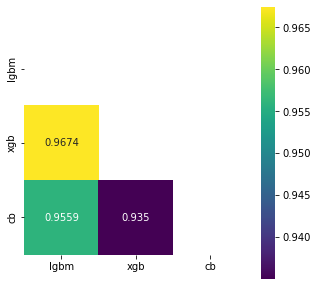

In [81]:
scores_train = pd.DataFrame({
    "lgbm": lgb_oof_preds,
    "xgb": xgb_oof,
    "cb": cb_oof
     })

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

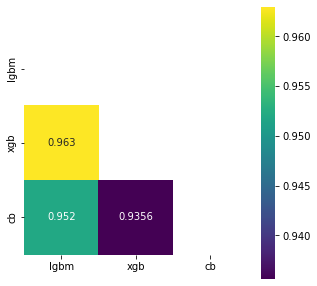

In [82]:
lgbm_pred_valid = lgb_estimators[0].predict_proba(x_valid)[:, 1]
xgb_pred_valid = xgb_estimators[0].predict_proba(x_valid)[:, 1]
cb_pred_valid = cb_estimators[0].predict_proba(x_valid)[:, 1]

scores_valid = pd.DataFrame({
    "lgbm": lgbm_pred_valid,
    "xgb": xgb_pred_valid,
    "cb": cb_pred_valid
     })

corr = scores_valid.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [83]:
val_statistics.loc['CB', 'score_valid'] = roc_auc_score(y_valid, cb_pred_valid)

In [84]:
## делаем то же, что и на предыдущем шаге, но для трех моделей.

In [85]:
scores_mean = scores_valid.mean(axis=1)

In [86]:
scores_valid.head()

,lgbm,xgb,cb
0,0.032902,0.038447,0.057457
1,0.107773,0.116343,0.122408
2,0.014553,0.006101,0.015271
3,0.053796,0.044722,0.065090
4,0.030630,0.034978,0.039587


In [87]:
scores_mean = scores_valid.mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

val_statistics.loc['AMean3', 'score_valid'] = score

Score = 0.7876


In [88]:
scores_mean = gmean(scores_valid, axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7866


In [89]:
val_statistics.loc['GMean3', 'score_valid'] = score

In [90]:
# ROC-AUC / GINI
scores_mean = scores_valid.rank().mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7847


In [91]:
val_statistics.loc['Rank3', 'score_valid'] = score

In [92]:
scores_mean = gmean(scores_valid.rank(), axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7832


In [93]:
val_statistics.loc['Rank_G3', 'score_valid'] = score

In [94]:
val_statistics

,score_valid
LightGBM,0.794234
XGBoost,0.784022
AMean2,0.793052
GMean2,0.792317
Rank,0.792002
Rank_G,0.790547
CB,0.767147
AMean3,0.787589
GMean3,0.78658
Rank3,0.784732


In [95]:
#наилучший скор на валидационной выборке был достигнут на LGBM, далее стекинг из средних скоров двух моделей: xgboost, LGBM. Добавление Catboost 
# только ухудшило score.

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [98]:
model_lr = LogisticRegression(random_state=1)
model_lr.fit(scores_valid, y_valid)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
lr_pred = model_lr.predict_proba(scores_valid)[:, 1]
lr_score = roc_auc_score(y_valid, lr_pred)
print(f"Score = {round(lr_score, 4)}")

val_statistics.loc['LogReg', 'score_valid'] = lr_score

Score = 0.7947


In [100]:
val_statistics

,score_valid
LightGBM,0.794234
XGBoost,0.784022
AMean2,0.793052
GMean2,0.792317
Rank,0.792002
Rank_G,0.790547
CB,0.767147
AMean3,0.787589
GMean3,0.78658
Rank3,0.784732


In [101]:
# лучшее качество - на логистической регрессии. Это заставляет задуматься над внедрением этого подхода в свою модель для курсового проекта.